In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from sklearn.decomposition import PCA


## Loading the images to create facial embeddings

In [2]:
# If device is "cuda" then GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Device: {device}")

Device: cpu


Loading the pre-trained model and using same parameters it was generated with

In [23]:
def whitens(img):
        mean = img.mean()
        std = img.std()
        std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
        y = (img - mean) / std_adj
        return y
    
def extract_features(mtcnn, facenet, img):
        img = img.to(device)
        img = transforms.ToPILImage()(img.squeeze_(0))
        bbs, _ = mtcnn.detect(img)
        if bbs is None:
            # if no face is detected
            return None, None

        faces = torch.stack([extract_face(img, bb) for bb in bbs])
        embeddings = facenet(whitens(faces)).detach().numpy()

        return bbs, embeddings
    
def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)
        
        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

In [24]:
mtcnn = MTCNN(keep_all=True, thresholds=[0.6, 0.7, 0.9], device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet = facenet.to(device)

In [25]:
dataset = datasets.ImageFolder(root='../DATASET/')
class_to_idx = dataset.class_to_idx
embeddings, labels = dataset_to_embeddings(dataset, mtcnn, facenet)

../DATASET/fake/person(100).jpg
../DATASET/fake/person(51).jpg
../DATASET/fake/person(52).jpg
../DATASET/fake/person(53).jpg
../DATASET/fake/person(54).jpg
../DATASET/fake/person(55).jpg
../DATASET/fake/person(56).jpg
../DATASET/fake/person(57).jpg
../DATASET/fake/person(58).jpg
../DATASET/fake/person(59).jpg
../DATASET/fake/person(60).jpg
../DATASET/fake/person(61).jpg
../DATASET/fake/person(62).jpg
../DATASET/fake/person(63).jpg
../DATASET/fake/person(64).jpg
../DATASET/fake/person(65).jpg
../DATASET/fake/person(66).jpg
../DATASET/fake/person(67).jpg
../DATASET/fake/person(68).jpg
../DATASET/fake/person(69).jpg
../DATASET/fake/person(70).jpg
../DATASET/fake/person(71).jpg
../DATASET/fake/person(72).jpg
../DATASET/fake/person(73).jpg
../DATASET/fake/person(74).jpg
../DATASET/fake/person(75).jpg
../DATASET/fake/person(76).jpg
../DATASET/fake/person(77).jpg
../DATASET/fake/person(78).jpg
../DATASET/fake/person(79).jpg
../DATASET/fake/person(80).jpg
../DATASET/fake/person(81).jpg
../DATA

In [26]:
print("Type of embeddings:", type(embeddings))
print("Amount of embeddings per image:", len(embeddings[0]))
print("Number of embeddings:", len(embeddings))
print("Number of images:", len(dataset.imgs))
print('Class to idx:', class_to_idx)

Type of embeddings: <class 'numpy.ndarray'>
Amount of embeddings per image: 512
Number of embeddings: 150
Number of images: 150
Class to idx: {'fake': 0, 'real': 1}


In [27]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
embeddings_list = [np.array(embed) for embed in embeddings]

embed_dataset = pd.DataFrame({
    "embeddings": embeddings_list,
    "label": [idx_to_class[img[1]] for img in dataset.imgs],
    "image": [os.path.basename(img[0]) for img in dataset.imgs]
})

In [28]:
embed_dataset.head()

,embeddings,label,image
0,"[0.020330984, -0.008105856, -0.058461007, -0.0...",fake,person(100).jpg
1,"[0.023804545, 0.08565126, -0.0044052457, 0.061...",fake,person(51).jpg
2,"[-0.030333875, 0.03799404, 0.005151561, 0.0555...",fake,person(52).jpg
3,"[0.05142098, 0.035230972, -0.030282672, 0.0292...",fake,person(53).jpg
4,"[-0.0288979, 0.013310195, 0.02452799, 0.006659...",fake,person(54).jpg


In [29]:
embed_dataset.to_pickle("embed_dataset.pkl")

## USING PCA TO REDUCE DIMENSIONALITY OF DATASET

In [30]:
embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

print(np.unique(labels))

dims_to_try = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {}

for d in dims_to_try:
    pca = PCA(n_components=d)
    reduced_embeddings = pca.fit_transform(embedding_matrix)
    pca_df = pd.DataFrame(reduced_embeddings)
    pca_df["label"] = labels
    pca_df["image"] = image
    pca_dfs[d] = pca_df

pca_dfs[10].head()

['fake' 'real']


,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.291422,0.317477,0.075411,0.000158,-0.147388,0.288108,0.251303,0.175951,-0.162314,-0.228309,fake,person(100).jpg
1,-0.371335,-0.017462,-0.101536,-0.060770,0.139662,-0.062701,-0.010073,0.141192,0.371749,0.079732,fake,person(51).jpg
2,-0.272213,-0.236490,0.251937,-0.166487,-0.044746,0.180711,0.164912,0.061101,0.234693,0.154980,fake,person(52).jpg
3,-0.368621,0.052717,-0.132578,-0.007529,-0.011192,0.273136,0.180583,0.025546,0.041748,-0.120930,fake,person(53).jpg
4,0.321207,-0.101999,0.214616,0.384748,0.194253,0.304419,-0.141555,0.051172,-0.097905,0.000950,fake,person(54).jpg


In [31]:
for x in pca_dfs.keys():
    pca_dfs[x].to_pickle("df_pca_"+str(x))

In [32]:
pd.read_pickle('df_pca_10').head()

,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.291422,0.317477,0.075411,0.000158,-0.147388,0.288108,0.251303,0.175951,-0.162314,-0.228309,fake,person(100).jpg
1,-0.371335,-0.017462,-0.101536,-0.060770,0.139662,-0.062701,-0.010073,0.141192,0.371749,0.079732,fake,person(51).jpg
2,-0.272213,-0.236490,0.251937,-0.166487,-0.044746,0.180711,0.164912,0.061101,0.234693,0.154980,fake,person(52).jpg
3,-0.368621,0.052717,-0.132578,-0.007529,-0.011192,0.273136,0.180583,0.025546,0.041748,-0.120930,fake,person(53).jpg
4,0.321207,-0.101999,0.214616,0.384748,0.194253,0.304419,-0.141555,0.051172,-0.097905,0.000950,fake,person(54).jpg


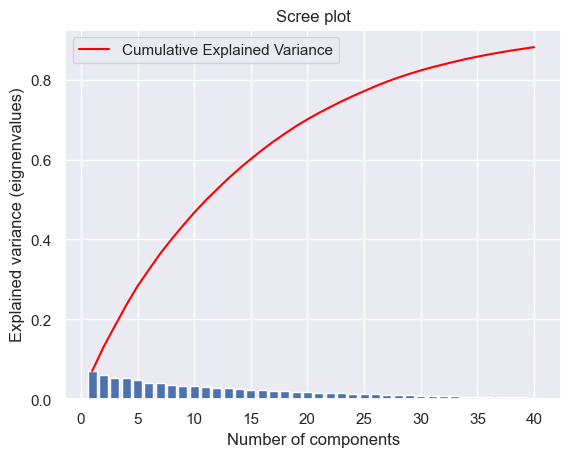

In [33]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

pca = PCA(n_components=40)
reduced_embeddings = pca.fit_transform(embedding_matrix)
pca_df = pd.DataFrame(reduced_embeddings)
pca_df["label"] = labels
pca_df["image"] = image
 
# Scree Plot
import numpy as np
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

# NMDS

breaking at iteration 2 with stress 0.30008204687523327
breaking at iteration 2 with stress 0.3008349314751823
breaking at iteration 2 with stress 0.3034651286969861
breaking at iteration 2 with stress 0.3018487908657891
breaking at iteration 3 with stress 0.3026185959782247
breaking at iteration 2 with stress 0.3015491143585579
breaking at iteration 2 with stress 0.3008734193771335
breaking at iteration 2 with stress 0.29847120971012736
breaking at iteration 2 with stress 0.2978856835135894
breaking at iteration 2 with stress 0.2980901595982931


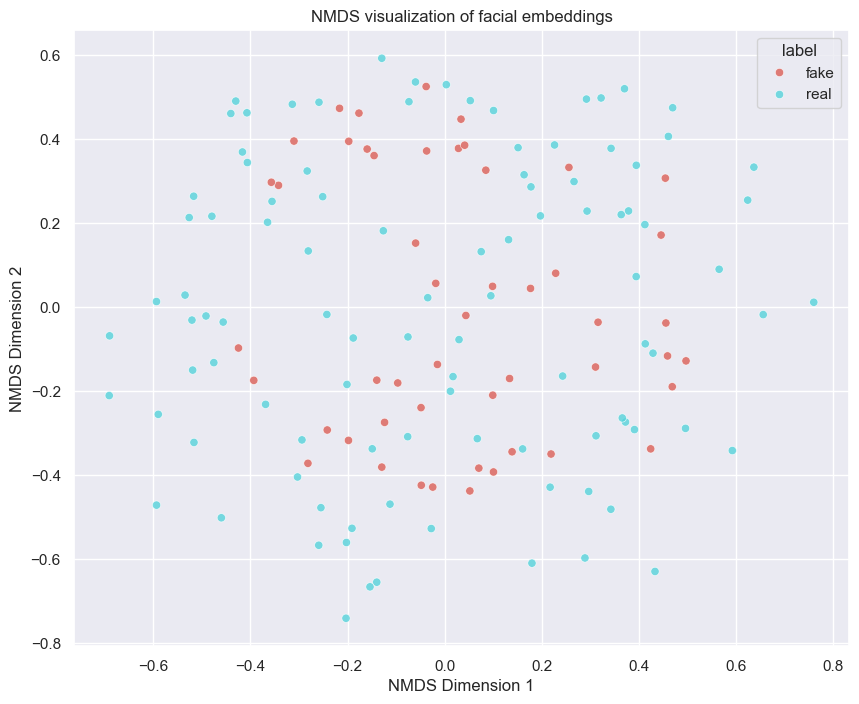

In [34]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

# Load your embeddings
embed_dataset = pd.read_pickle('embed_dataset.pkl')  # or whatever your pickle file is named
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

# Apply NMDS - you can try different n_components values
n_components = 2  # For 2D visualization
nmds = MDS(n_components=n_components, metric=False, random_state=42, 
           n_init=10, max_iter=300, verbose=1, eps=1e-6, 
           dissimilarity='euclidean')
reduced_embeddings = nmds.fit_transform(embedding_matrix)

# Create a DataFrame with the reduced dimensions
nmds_df = pd.DataFrame(reduced_embeddings)
nmds_df["label"] = labels
nmds_df["image"] = image

# Save the NMDS DataFrame
nmds_df.to_pickle(f"df_nmds_{n_components}")

# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=nmds_df,
    legend="full",
    alpha=0.8
)
plt.title('NMDS visualization of facial embeddings')
plt.xlabel('NMDS Dimension 1')
plt.ylabel('NMDS Dimension 2')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


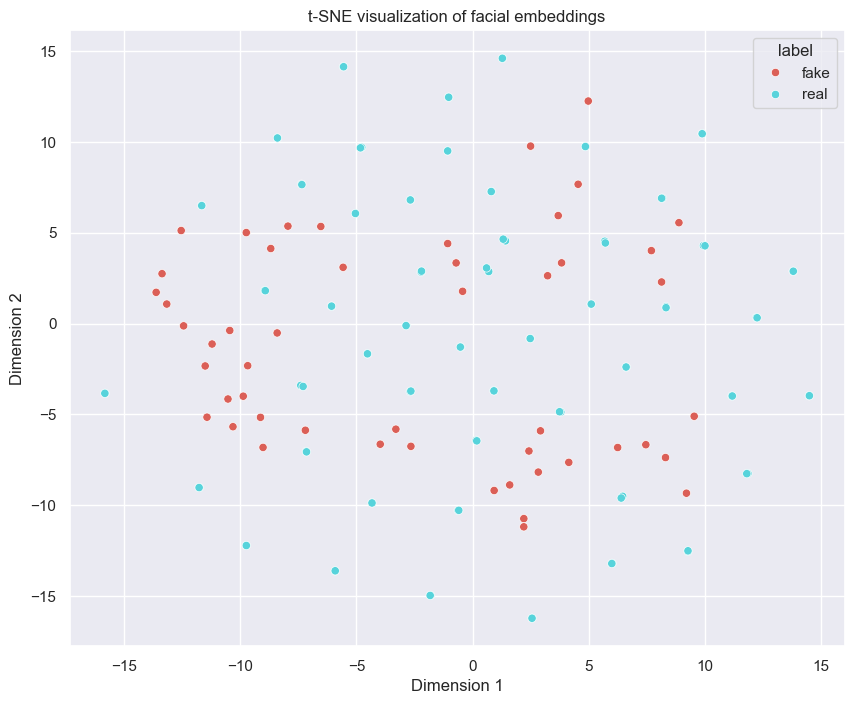

In [35]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

tsne_df = pd.DataFrame(reduced_embeddings, columns=['Dimension 1', 'Dimension 2'])
tsne_df["label"] = labels
tsne_df["image"] = image

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimension 1', y='Dimension 2',
    hue="label",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=tsne_df,
    legend="full"
)
plt.title('t-SNE visualization of facial embeddings')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


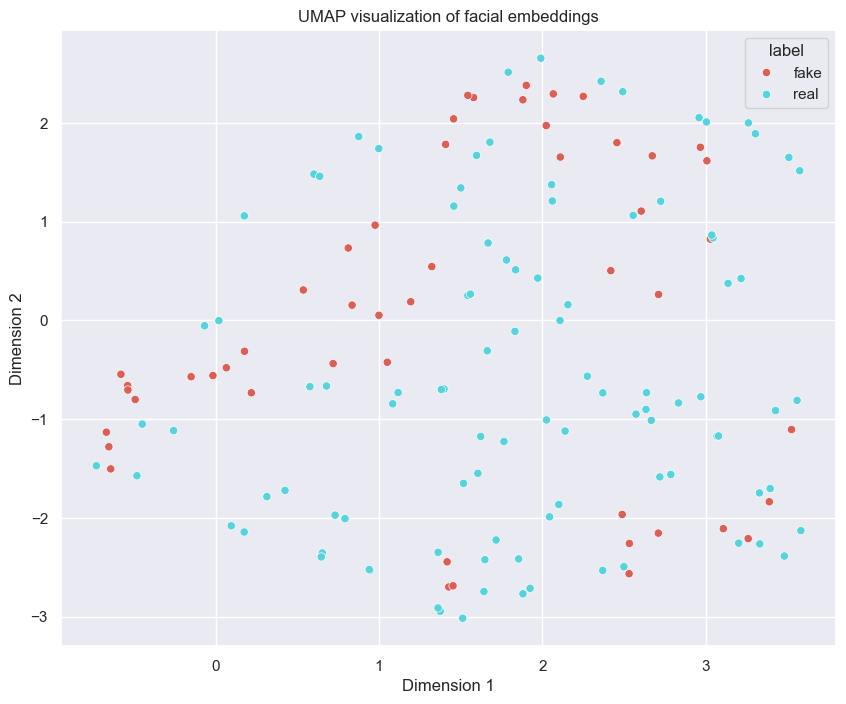

In [36]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embedding_matrix)

umap_df = pd.DataFrame(reduced_embeddings, columns=['Dimension 1', 'Dimension 2'])
umap_df["label"] = labels
umap_df["image"] = image

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimension 1', y='Dimension 2',
    hue="label",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=umap_df,
    legend="full"
)
plt.title('UMAP visualization of facial embeddings')
plt.show()

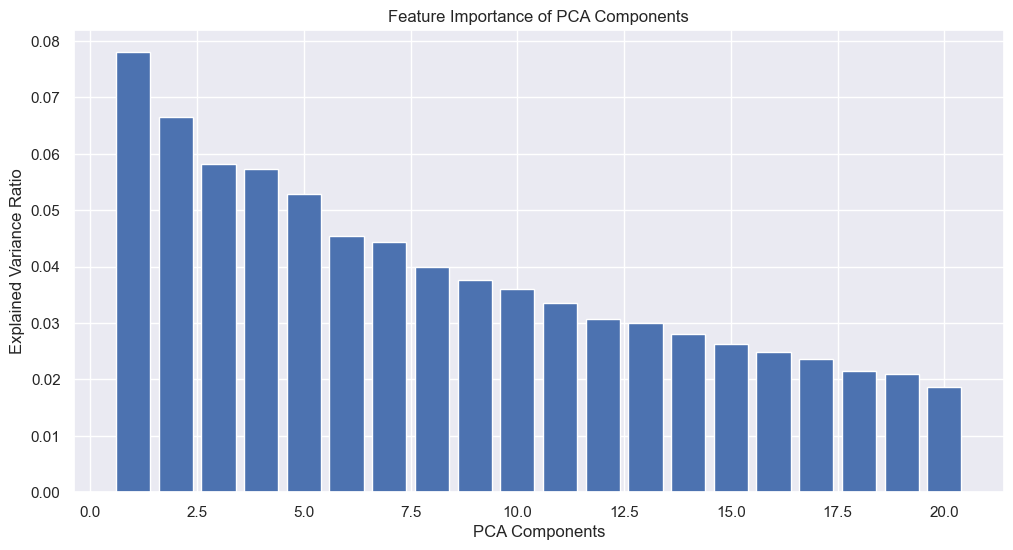

In [37]:
# After fitting PCA
pca = PCA(n_components=20)
pca.fit(embedding_matrix)

# Plot feature importance
plt.figure(figsize=(12, 6))
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(components, pca.explained_variance_ratio_)
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Feature Importance of PCA Components')
plt.show()

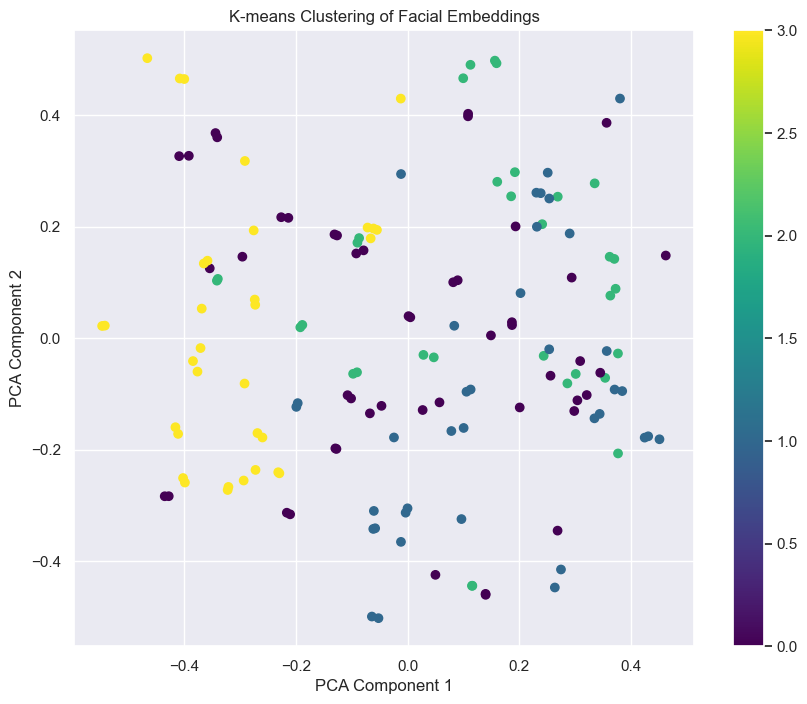

actual_label  fake  real
cluster                 
0               18    30
1               13    24
2               10    22
3                9    24


In [38]:
from sklearn.cluster import KMeans

# Try different numbers of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embedding_matrix)

# Use PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Facial Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Compare clusters with your actual labels
cluster_df = pd.DataFrame({
    'cluster': clusters,
    'actual_label': labels
})
print(pd.crosstab(cluster_df['cluster'], cluster_df['actual_label']))